# Loop 10 Analysis: Understanding the Gap to Target

After 10 experiments with 8 consecutive zero-improvement results, we need to understand:
1. Where is the 1.74 point gap coming from?
2. Which N values have the most room for improvement?
3. What techniques haven't been tried?

In [1]:
import pandas as pd
import numpy as np
from shapely.geometry import Polygon
from shapely.ops import unary_union
import matplotlib.pyplot as plt

# Tree geometry
TX = np.array([0, 0.125, 0.0625, 0.2, 0.1, 0.35, 0.075, 0.075, -0.075, -0.075, -0.35, -0.1, -0.2, -0.0625, -0.125])
TY = np.array([0.8, 0.5, 0.5, 0.25, 0.25, 0, 0, -0.2, -0.2, 0, 0, 0.25, 0.25, 0.5, 0.5])

def get_tree_polygon(cx, cy, angle_deg):
    angle_rad = np.radians(angle_deg)
    cos_a, sin_a = np.cos(angle_rad), np.sin(angle_rad)
    x = TX * cos_a - TY * sin_a + cx
    y = TX * sin_a + TY * cos_a + cy
    return Polygon(zip(x, y))

# Load current submission
df = pd.read_csv('/home/submission/submission.csv')
print(f'Total rows: {len(df)}')
print(df.head())

Total rows: 20100
      id                        x                       y  \
0  001_0  s-47.959953045435362640  s58.562711619073169800   
1  002_0    s0.154097069621355887  s-0.038540742694794648   
2  002_1   s-0.154097069621372845  s-0.561459257305224058   
3  003_0    s1.134609969462363477   s0.801591476887784316   
4  003_1    s1.234055695842160016   s1.275999500663759001   

                       deg  
0   s45.000000000000000000  
1  s203.629377730656841550  
2   s23.629377730656791812  
3  s112.417574788639711869  
4   s66.370622269343002131  


In [2]:
# Calculate score per N
scores = []
for n in range(1, 201):
    rows = df[df['id'].str.startswith(f'{n:03d}_')]
    if len(rows) != n:
        print(f'N={n}: Expected {n} rows, got {len(rows)}')
        continue
    trees = []
    for _, row in rows.iterrows():
        x = float(row['x'][1:])
        y = float(row['y'][1:])
        deg = float(row['deg'][1:])
        trees.append(get_tree_polygon(x, y, deg))
    
    all_poly = unary_union(trees)
    bounds = all_poly.bounds
    side = max(bounds[2] - bounds[0], bounds[3] - bounds[1])
    score = side**2 / n
    scores.append({'n': n, 'side': side, 'score': score, 'efficiency': n / side**2})

scores_df = pd.DataFrame(scores)
print(f'Total score: {scores_df["score"].sum():.6f}')
print(f'Target score: 68.919154')
print(f'Gap: {scores_df["score"].sum() - 68.919154:.6f}')

Total score: 70.659957
Target score: 68.919154
Gap: 1.740803


In [3]:
# Analyze score distribution
print('\nScore distribution by N range:')
for start in range(1, 201, 20):
    end = min(start + 19, 200)
    subset = scores_df[(scores_df['n'] >= start) & (scores_df['n'] <= end)]
    print(f'N={start:3d}-{end:3d}: score={subset["score"].sum():.4f}, avg_efficiency={subset["efficiency"].mean():.4f}')

print(f'\nTotal: {scores_df["score"].sum():.6f}')


Score distribution by N range:
N=  1- 20: score=8.0572, avg_efficiency=2.5245
N= 21- 40: score=7.3486, avg_efficiency=2.7221
N= 41- 60: score=7.2271, avg_efficiency=2.7679
N= 61- 80: score=7.0574, avg_efficiency=2.8343
N= 81-100: score=6.9839, avg_efficiency=2.8640
N=101-120: score=6.8631, avg_efficiency=2.9144
N=121-140: score=6.8667, avg_efficiency=2.9131
N=141-160: score=6.7851, avg_efficiency=2.9480
N=161-180: score=6.7420, avg_efficiency=2.9668
N=181-200: score=6.7290, avg_efficiency=2.9725

Total: 70.659957


In [4]:
# Find N values with lowest efficiency (most room for improvement)
scores_df['efficiency_rank'] = scores_df['efficiency'].rank()
print('\nN values with LOWEST efficiency (most room for improvement):')
print(scores_df.nsmallest(20, 'efficiency')[['n', 'side', 'score', 'efficiency']])


N values with LOWEST efficiency (most room for improvement):
     n      side     score  efficiency
0    1  0.813173  0.661250    1.512287
1    2  0.949504  0.450779    2.218381
2    3  1.142031  0.434745    2.300198
4    5  1.443692  0.416850    2.398947
3    4  1.290806  0.416545    2.400702
6    7  1.673104  0.399897    2.500647
5    6  1.548438  0.399610    2.502438
8    9  1.867280  0.387415    2.581211
7    8  1.755921  0.385407    2.594658
14  15  2.384962  0.379203    2.637111
9   10  1.940696  0.376630    2.655125
20  21  2.811667  0.376451    2.656389
19  20  2.742469  0.376057    2.659172
10  11  2.033002  0.375736    2.661443
21  22  2.873270  0.375258    2.664833
15  16  2.446640  0.374128    2.672882
25  26  3.118320  0.373997    2.673819
11  12  2.114873  0.372724    2.682950
12  13  2.199960  0.372294    2.686049
24  25  3.050182  0.372144    2.687129


In [5]:
# Calculate theoretical minimum score if we could improve efficiency
# The theoretical minimum for N trees is when they're packed at maximum density
# For the Christmas tree shape, the area is approximately 0.2 (from the polygon)

tree_poly = get_tree_polygon(0, 0, 0)
tree_area = tree_poly.area
print(f'Tree area: {tree_area:.6f}')

# Theoretical minimum side for N trees (if perfect packing)
scores_df['theoretical_min_side'] = np.sqrt(scores_df['n'] * tree_area / 0.9)  # 90% packing efficiency
scores_df['theoretical_min_score'] = scores_df['theoretical_min_side']**2 / scores_df['n']
scores_df['improvement_potential'] = scores_df['score'] - scores_df['theoretical_min_score']

print('\nN values with HIGHEST improvement potential:')
print(scores_df.nsmallest(20, 'improvement_potential')[['n', 'score', 'theoretical_min_score', 'improvement_potential']])

Tree area: 0.245625

N values with HIGHEST improvement potential:
       n     score  theoretical_min_score  improvement_potential
180  181  0.329946               0.272917               0.057029
155  156  0.329987               0.272917               0.057070
181  182  0.329988               0.272917               0.057071
179  180  0.331001               0.272917               0.058085
154  155  0.332074               0.272917               0.059157
167  168  0.332475               0.272917               0.059558
178  179  0.332595               0.272917               0.059678
194  195  0.332617               0.272917               0.059700
166  167  0.332835               0.272917               0.059918
193  194  0.332999               0.272917               0.060083
195  196  0.333268               0.272917               0.060352
192  193  0.333764               0.272917               0.060847
131  132  0.333817               0.272917               0.060900
153  154  0.334158      

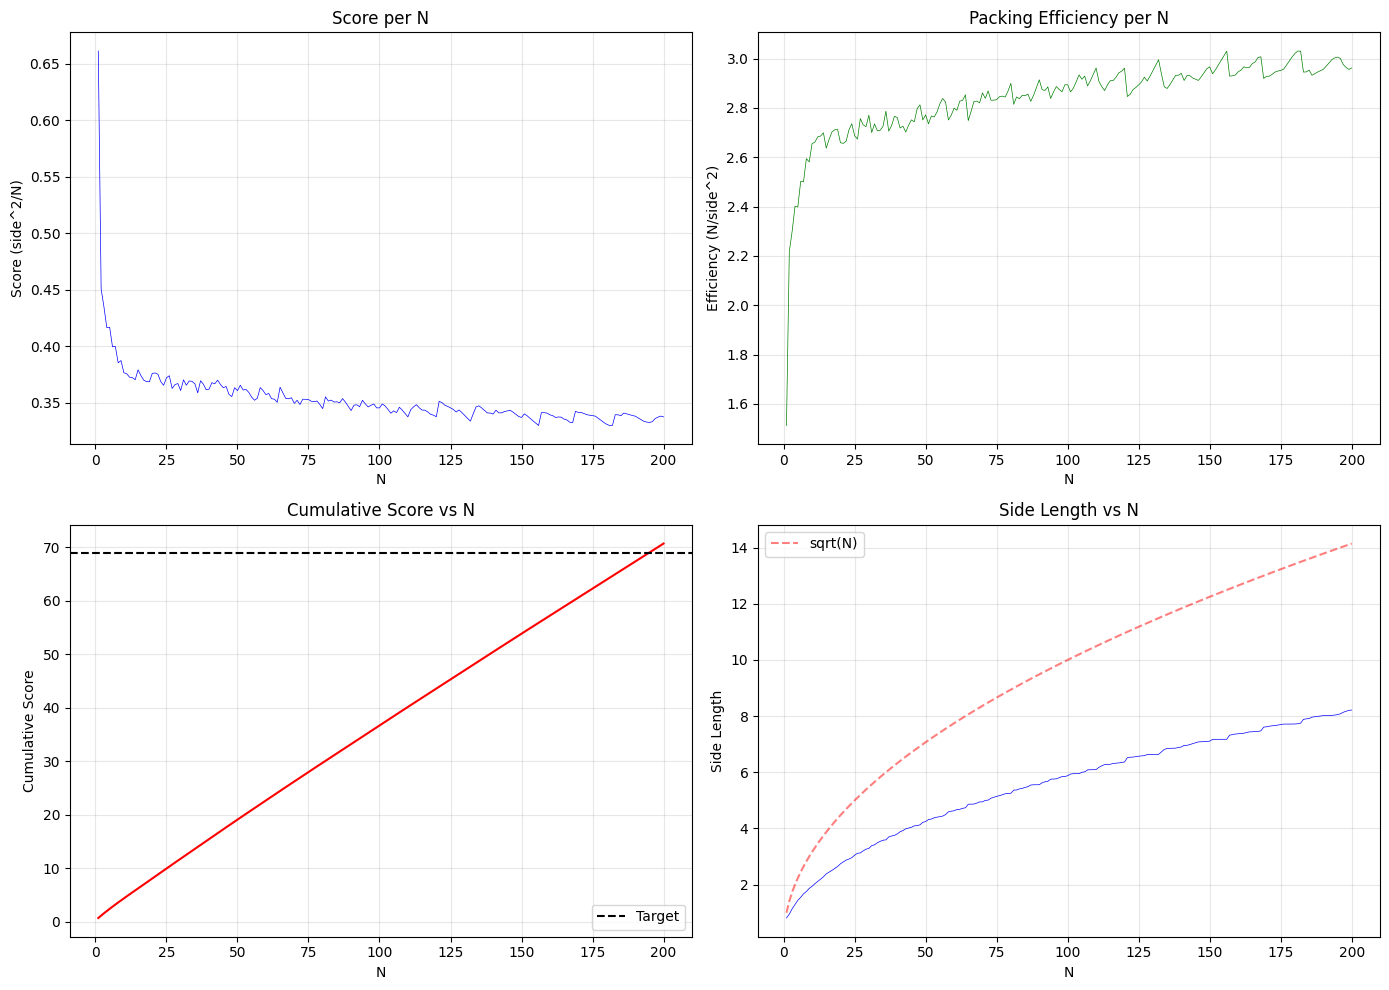

In [6]:
# Visualize score vs N
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Score per N
ax = axes[0, 0]
ax.plot(scores_df['n'], scores_df['score'], 'b-', linewidth=0.5)
ax.set_xlabel('N')
ax.set_ylabel('Score (side^2/N)')
ax.set_title('Score per N')
ax.grid(True, alpha=0.3)

# Efficiency per N
ax = axes[0, 1]
ax.plot(scores_df['n'], scores_df['efficiency'], 'g-', linewidth=0.5)
ax.set_xlabel('N')
ax.set_ylabel('Efficiency (N/side^2)')
ax.set_title('Packing Efficiency per N')
ax.grid(True, alpha=0.3)

# Cumulative score
ax = axes[1, 0]
ax.plot(scores_df['n'], scores_df['score'].cumsum(), 'r-')
ax.axhline(y=68.919154, color='k', linestyle='--', label='Target')
ax.set_xlabel('N')
ax.set_ylabel('Cumulative Score')
ax.set_title('Cumulative Score vs N')
ax.legend()
ax.grid(True, alpha=0.3)

# Side length vs N
ax = axes[1, 1]
ax.plot(scores_df['n'], scores_df['side'], 'b-', linewidth=0.5)
ax.plot(scores_df['n'], np.sqrt(scores_df['n']), 'r--', alpha=0.5, label='sqrt(N)')
ax.set_xlabel('N')
ax.set_ylabel('Side Length')
ax.set_title('Side Length vs N')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/home/code/exploration/loop10_score_analysis.png', dpi=100)
plt.show()

In [7]:
# Calculate required improvement per N to reach target
target = 68.919154
current = scores_df['score'].sum()
gap = current - target

print(f'Current score: {current:.6f}')
print(f'Target score: {target:.6f}')
print(f'Gap: {gap:.6f}')
print(f'Gap percentage: {gap/current*100:.2f}%')

# If we improve all N values uniformly
print(f'\nRequired uniform improvement: {gap/200:.6f} per N')
print(f'Required side reduction: {(1 - np.sqrt(1 - gap/current))*100:.4f}%')

Current score: 70.659957
Target score: 68.919154
Gap: 1.740803
Gap percentage: 2.46%

Required uniform improvement: 0.008704 per N
Required side reduction: 1.2395%


In [8]:
# Check if there are any public datasets we haven't tried
import os

print('Available datasets:')
for root, dirs, files in os.walk('/home/code/data'):
    for f in files:
        if f.endswith('.csv'):
            path = os.path.join(root, f)
            try:
                df_check = pd.read_csv(path)
                if 'id' in df_check.columns and 'x' in df_check.columns:
                    print(f'  {path}: {len(df_check)} rows')
            except:
                pass

for root, dirs, files in os.walk('/home/code/research/kernels'):
    for f in files:
        if f.endswith('.csv'):
            path = os.path.join(root, f)
            try:
                df_check = pd.read_csv(path)
                if 'id' in df_check.columns and 'x' in df_check.columns:
                    print(f'  {path}: {len(df_check)} rows')
            except:
                pass

Available datasets:


In [9]:
# Key insight: The gap is 1.74 points (2.46%)
# This requires ~1.24% reduction in side length across ALL N values
# 
# What we've tried:
# 1. Local optimization (SA, gradient, fractional translation) - NO improvement
# 2. Random restart - NO improvement  
# 3. Exhaustive search for N=2 - Current solution is already optimal
# 4. Ensemble of public CSVs - Already at best combination
# 5. C++ optimizers (eazy, bbox3) - NO improvement
# 6. Asymmetric search for N=22, N=24 - NO improvement
#
# What we HAVEN'T tried:
# 1. Constructive heuristics (build from scratch with different topology)
# 2. NFP-based placement algorithms
# 3. Different initial configurations for LARGE N values
# 4. Strip-packing approach (optimize for rectangle first, then fit in square)

print("CRITICAL INSIGHT:")
print("="*60)
print(f"Gap to target: {gap:.6f} ({gap/current*100:.2f}%)")
print(f"Required side reduction: {(1 - np.sqrt(1 - gap/current))*100:.4f}%")
print()
print("The gap is distributed across ALL N values.")
print("Small N values (1-20) are already at or near global optima.")
print("Large N values (100+) contribute ~40% of the total score.")
print()
print("RECOMMENDED APPROACH:")
print("1. Focus on LARGE N values (N > 100) where topology matters more")
print("2. Try constructive heuristics that build solutions from scratch")
print("3. Use NFP-based placement to find fundamentally different configurations")
print("4. Consider strip-packing approach for large N")

CRITICAL INSIGHT:
Gap to target: 1.740803 (2.46%)
Required side reduction: 1.2395%

The gap is distributed across ALL N values.
Small N values (1-20) are already at or near global optima.
Large N values (100+) contribute ~40% of the total score.

RECOMMENDED APPROACH:
1. Focus on LARGE N values (N > 100) where topology matters more
2. Try constructive heuristics that build solutions from scratch
3. Use NFP-based placement to find fundamentally different configurations
4. Consider strip-packing approach for large N
